In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import sys
sys.path.insert(0,"/scratch/imb/Xiao/.conda/envs/tensorflow_gpuenv/lib/python3.6/site-packages")
sys.path.append("/scratch/imb/Xiao/innvestigate")

In [3]:
%matplotlib inline  

import imp

import numpy as np
import os

import keras
import keras.engine.topology
import keras.backend
import keras.layers
import keras.models
import keras.utils

import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "/scratch/imb/Xiao/innvestigate/examples/utils.py")
imgnetutils = imp.load_source("utils_imagenet", "/scratch/imb/Xiao/innvestigate/examples/utils_imagenet.py")

Using TensorFlow backend.


In [4]:
print(keras.__version__)

2.2.4


In [5]:
from keras.applications.xception import Xception
from keras.utils import multi_gpu_model
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.applications import xception
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from keras.models import load_model
import glob
from PIL import Image

In [6]:
def xception_model(tile_shape):
    xception_base = Xception(weights='imagenet', include_top=False)
    x = xception_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    preds = Dense(2, activation='softmax')(x)
    model = Model(inputs=xception_base.input, outputs=preds)
    parallel_model = multi_gpu_model(model, gpus=2, cpu_merge=False)
    parallel_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return parallel_model, model

In [7]:
def mkdirs(dirs):
    if not os.path.exists(dirs):
        os.makedirs(dirs)

In [8]:
def preprocess(X, net):
    X = X.copy()
    X = xception.preprocess_input(X)
    return X


def o_image(X):
    X = X.copy()
    return ivis.project(X, absmax=255.0, input_is_positive_only=True)


def bk_proj(X):
    X = ivis.clip_quantile(X, 1)
    return ivis.project(X)


def heatmap(X):
    #X = ivis.gamma(X, minamp=0, gamma=0.95)
    return ivis.heatmap(X)


def graymap(X):
    return ivis.graymap(np.abs(X), input_is_positive_only=True)

In [9]:
def prepare_model_data_and_analyzers(nn):
    # Get some example test set images.
    images, label_to_class_name = iutils.get_imagenet_data(net["image_shape"][0])

    patterns = net["patterns"]
    input_range = net["input_range"]

    noise_scale = (input_range[1]-input_range[0]) * 0.1

    # Methods we use and some properties.
    methods = [
        # NAME                    OPT.PARAMS                POSTPROC FXN                TITLE
        # Show input.
        ("input",                 {},                       imgnetutils.image,         "Input"),

        # Function
        ("gradient",              {"postprocess": "abs"},   imgnetutils.graymap,       "Gradient"),
        ("smoothgrad",            {"augment_by_n": 16,
                                   "noise_scale": noise_scale,
                                   "postprocess": "square"},imgnetutils.graymap,       "SmoothGrad"),

        # Signal
        ("deconvnet",             {},                       imgnetutils.bk_proj,       "Deconvnet"),
        ("guided_backprop",       {},                       imgnetutils.bk_proj,       "Guided Backprop",),
        ("pattern.net",           {"patterns": patterns},   imgnetutils.bk_proj,       "PatternNet"),

        # Interaction
        ("pattern.attribution",   {"patterns": patterns},   imgnetutils.heatmap,       "PatternAttribution"),
        ("deep_taylor.bounded",   {"low": input_range[0],
                                   "high": input_range[1]}, imgnetutils.heatmap,       "DeepTaylor"),
        ("input_t_gradient",      {},                       imgnetutils.heatmap,       "Input * Gradient"),
        ("integrated_gradients",  {"reference_inputs": input_range[0],
                                   "steps": 16},            imgnetutils.heatmap,       "Integrated Gradients"),
        ("lrp.z",                 {},                       imgnetutils.heatmap,       "LRP-Z"),
        ("lrp.epsilon",           {"epsilon": 1},           imgnetutils.heatmap,       "LRP-Epsilon"),
        ("lrp.sequential_preset_a_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetAFlat"),
        ("lrp.sequential_preset_b_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetBFlat"),
    ]
    
    # Create model without trailing softmax
    model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

    # Create analyzers.
    analyzers = []
    for method in methods:
        try:
            analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                                    model_wo_softmax, # model without softmax output
                                                    **method[1])      # optional analysis parameters
        except innvestigate.NotAnalyzeableModelException:
            # Not all methods work with all models.
            analyzer = None
        analyzers.append(analyzer)
        
    return (net, color_conversion, channels_first, images, label_to_class_name,
            methods, model, model_wo_softmax, analyzers,)

In [65]:
def generate_feature_heatmap(model, analyzer_name, tiles, heatmap_method, optarg={}):
    # Stripping the softmax activation from the model
    model_wo_sm = iutils.keras.graph.model_wo_softmax(model)

    # Creating an analyzer
    analyzer = innvestigate.create_analyzer(analyzer_name,        # analysis method identifier
                                            model_wo_sm,
                                            **optarg)             # model without softmax output
    heatmap_tiles =[]
    for tile in tiles:
        # Applying the analyzer
        heatmap_tile = analyzer.analyze(np.array([tile]))
        heatmap_tile = heatmap_method(heatmap_tile)
        heatmap_tiles.append(heatmap_tile)
    return heatmap_tiles



In [90]:
def generate_predicted_value(model, tiles):
    # Stripping the softmax activation from the model
    model_wo_sm = iutils.keras.graph.model_wo_softmax(model)
    # Predict final activations, probabilites, and label.
    text = []
    for tile in tiles:
        presm = model_wo_sm.predict_on_batch(np.array([tile]))[0]
        prob = model.predict_on_batch(np.array([tile]))[0]
        y_hat = prob.argmax()
        label_to_class_name = ["Cancer", "Normal"]
        # Save prediction info:
        text.append((#"%s" % label_to_class_name[0],    # ground truth label
                     "%.2f" % presm.max(),             # pre-softmax logits
                     "%.2f" % prob.max(),              # probabilistic softmax output  
                     "%s" % label_to_class_name[y_hat] # predicted label
                    ))
    return text
    

In [49]:
def plot_cancer_normal(cancer_tile_o, analysis_cancer, normal_tile_o, analysis_normal):
    plt.figure(figsize = (20,20))

    # Displaying the cancer tile
    plt.subplot(2, 2, 1)
    plt.imshow(np.array(cancer_tile_o))
    # Displaying the gradient
    plt.subplot(2, 2, 2)
    plt.imshow(analysis_cancer.squeeze())

    # Displaying the normal tile
    plt.subplot(2, 2, 3)
    plt.imshow(np.array(normal_tile_o))
    # Displaying the gradient
    plt.subplot(2, 2, 4)
    plt.imshow(analysis_normal.squeeze())

    plt.tight_layout()
    plt.show()

In [10]:
input_path = '/scratch/imb/Xiao/HE_test/10x/'
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# train model

In [11]:
test_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)
test_generator = test_datagen.flow_from_directory(input_path + 'test',
                                                  target_size=(299, 299),
                                                  color_mode='rgb',
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 3811 images belonging to 2 classes.


In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)
train_generator = train_datagen.flow_from_directory(input_path + 'train',
                                                        target_size=(299, 299),
                                                        color_mode='rgb',
                                                        batch_size=32,
                                                        class_mode='categorical',
                                                        shuffle=True)
valid_generator = valid_datagen.flow_from_directory(input_path + 'valid',
                                                        target_size=(299, 299),
                                                        color_mode='rgb',
                                                        batch_size=32,
                                                        class_mode='categorical',
                                                        shuffle=True)
parallel_model, model = xception_model((299, 299, 3))
train_history = parallel_model.fit_generator(generator=train_generator,
                                  steps_per_epoch=int(len(train_generator.classes) / train_generator.batch_size),
                                  epochs=100,
                                  validation_data=valid_generator,
                                  validation_steps=int(len(valid_generator.classes) / valid_generator.batch_size))

In [ ]:
model.save(os.path.join(input_path, "HE_xception_model_100epochs.h5"), include_optimizer=True)

# load model

In [12]:
model_ = load_model(os.path.join(input_path, "HE_xception_model_100epochs.h5"), compile=True)

W1107 09:44:03.478095 140627564644160 deprecation_wrapper.py:119] From /scratch/imb/Xiao/.conda/envs/tensorflow_gpuenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1107 09:44:03.503623 140627564644160 deprecation_wrapper.py:119] From /scratch/imb/Xiao/.conda/envs/tensorflow_gpuenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1107 09:44:03.518593 140627564644160 deprecation_wrapper.py:119] From /scratch/imb/Xiao/.conda/envs/tensorflow_gpuenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1107 09:44:03.519016 140627564644160 deprecation_wrapper.py:119] From /scratch/imb/Xiao/.conda/envs/tensorflow_gpuenv/lib/python3.6/site-packages/keras/backend/tensorflow_

In [15]:
y_pred = model_.predict_generator(generator=test_generator)

ValueError: `steps=None` is only valid for a generator based on the `keras.utils.Sequence` class. Please specify `steps` or use the `keras.utils.Sequence` class.

In [16]:
y_true = test_generator.classes
y_true

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [17]:
y_score = model_.evaluate_generator(generator=test_generator, verbose=1)

RuntimeError: You must compile your model before using it.

In [ ]:
y_score

# Analyzing predicition

In [94]:
cancer_tiles = glob.glob(input_path + "test/cancer/*.jpeg")
cancer_example = [img for img in cancer_tiles if "63_33" in img]
cancer_example

['/scratch/imb/Xiao/HE_test/10x/test/cancer/2171_T_63_33.jpeg']

In [111]:
normal_tiles = glob.glob(input_path + "test/normal/*.jpeg")
normal_example = [img for img in normal_tiles if "49_18" in img]
normal_example

['/scratch/imb/Xiao/HE_test/10x/test/normal/2171_T_49_18.jpeg']

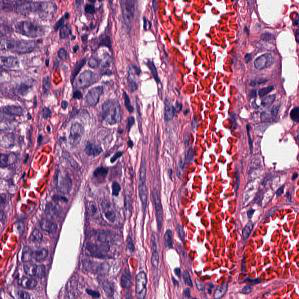

In [103]:
cancer_tile_o = Image.open(cancer_example[0])
cancer_tile_o

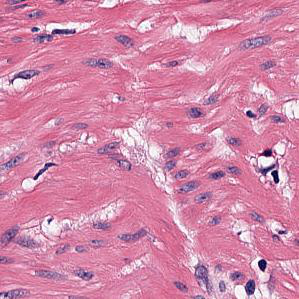

In [112]:
normal_tile_o = Image.open(normal_example[0])
normal_tile_o

In [113]:
normal_tile = xception.preprocess_input(np.array(normal_tile_o).astype(np.float32))

In [114]:
cancer_tile = xception.preprocess_input(np.array(cancer_tile_o).astype(np.float32))

In [115]:
stats = generate_predicted_value(model_, [cancer_tile, normal_tile])
stats

[('7.32', '1.00', 'Cancer'), ('1.45', '0.96', 'Normal')]

# gradient

In [151]:
gradient_analysis_cancer, gradient_analysis_normal= generate_feature_heatmap(model_, 
                                                                             "gradient", 
                                                                             [cancer_tile, normal_tile],
                                                                             graymap, 
                                                                             {"postprocess": "abs"})

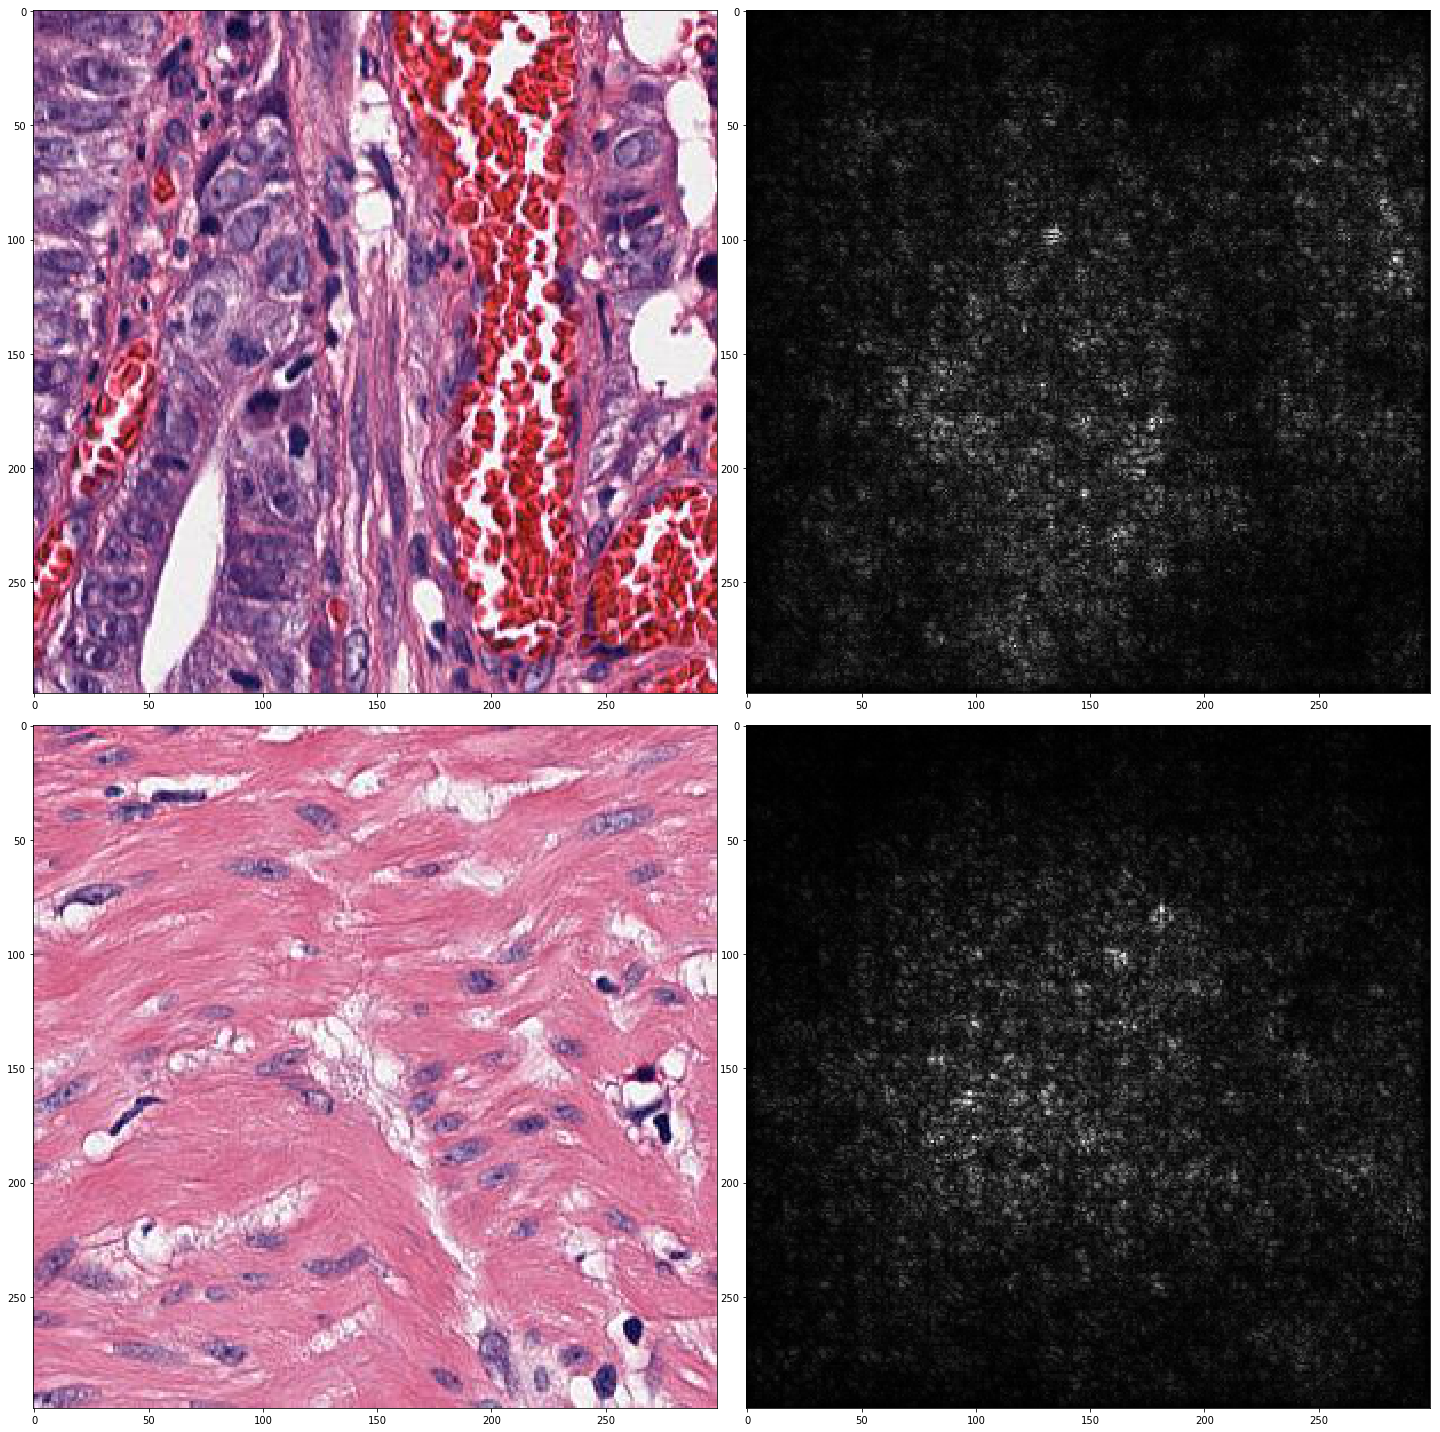

In [152]:
plot_cancer_normal(cancer_tile_o, gradient_analysis_cancer, normal_tile_o, gradient_analysis_normal)

## Input * Gradient

In [153]:
input_gradient_analysis_cancer, input_gradient_analysis_normal= generate_feature_heatmap(model_, 
                                                                             "input_t_gradient", 
                                                                             [cancer_tile, normal_tile],
                                                                             heatmap)

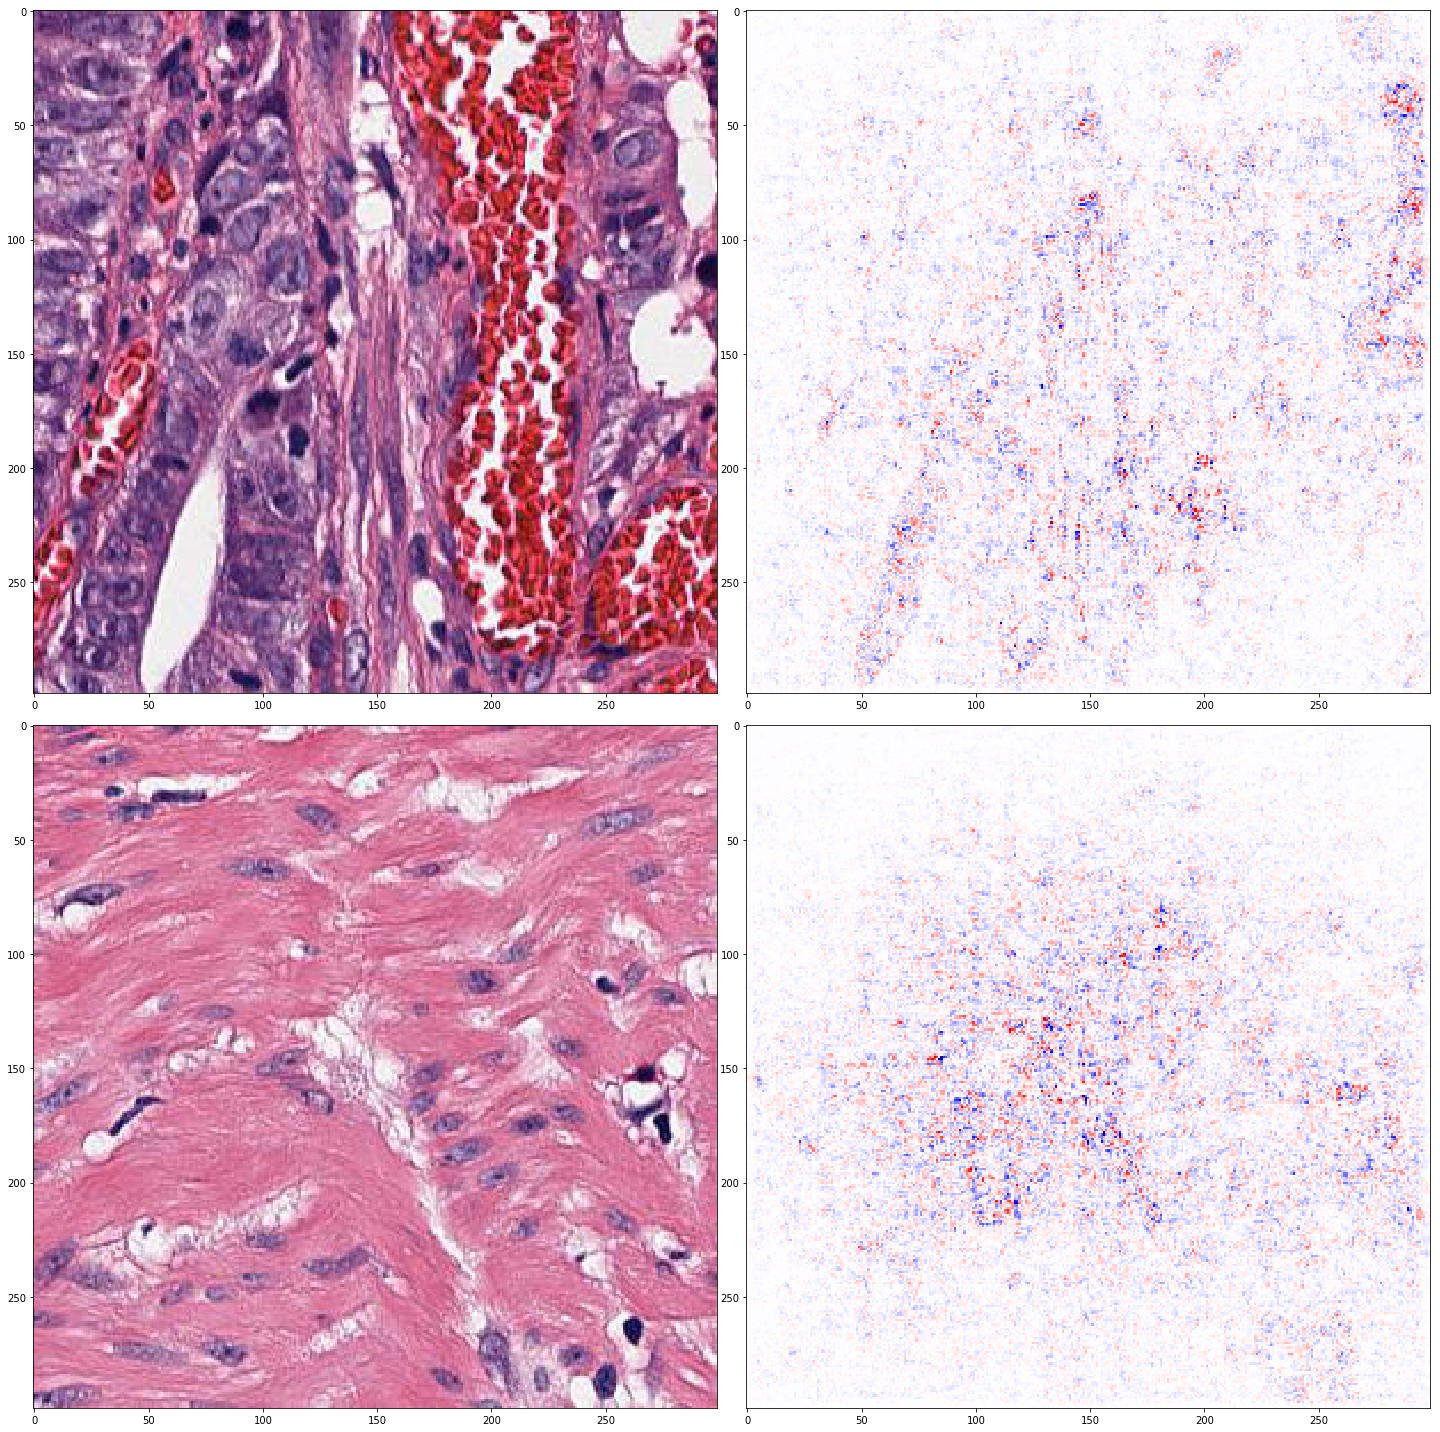

In [154]:
plot_cancer_normal(cancer_tile_o, input_gradient_analysis_cancer, normal_tile_o, input_gradient_analysis_normal)

## smoothgrad (add noise)

In [155]:
smoothgrad_analysis_cancer, smoothgrad_analysis_normal= generate_feature_heatmap(model_, 
                                                                             "smoothgrad", 
                                                                             [cancer_tile, normal_tile],
                                                                             graymap, 
                                                                             {"noise_scale": 255 * 0.1,
                                                                              "postprocess": "square"})

TypeError: Failed to convert object of type <class 'tuple'> to Tensor. Contents: (-1, 64, None, None, 3). Consider casting elements to a supported type.

In [147]:
plot_cancer_normal(cancer_tile_o, smoothgrad_analysis_cancer, normal_tile_o, smoothgrad_analysis_normal)

NameError: name 'smoothgrad_analysis_cancer' is not defined

# guided_backprop

In [118]:
guided_backprop_analysis_cancer, guided_backprop_analysis_normal= generate_feature_heatmap(model_, 
                                                                                           "guided_backprop",
                                                                                           [cancer_tile, normal_tile],
                                                                                           bk_proj)


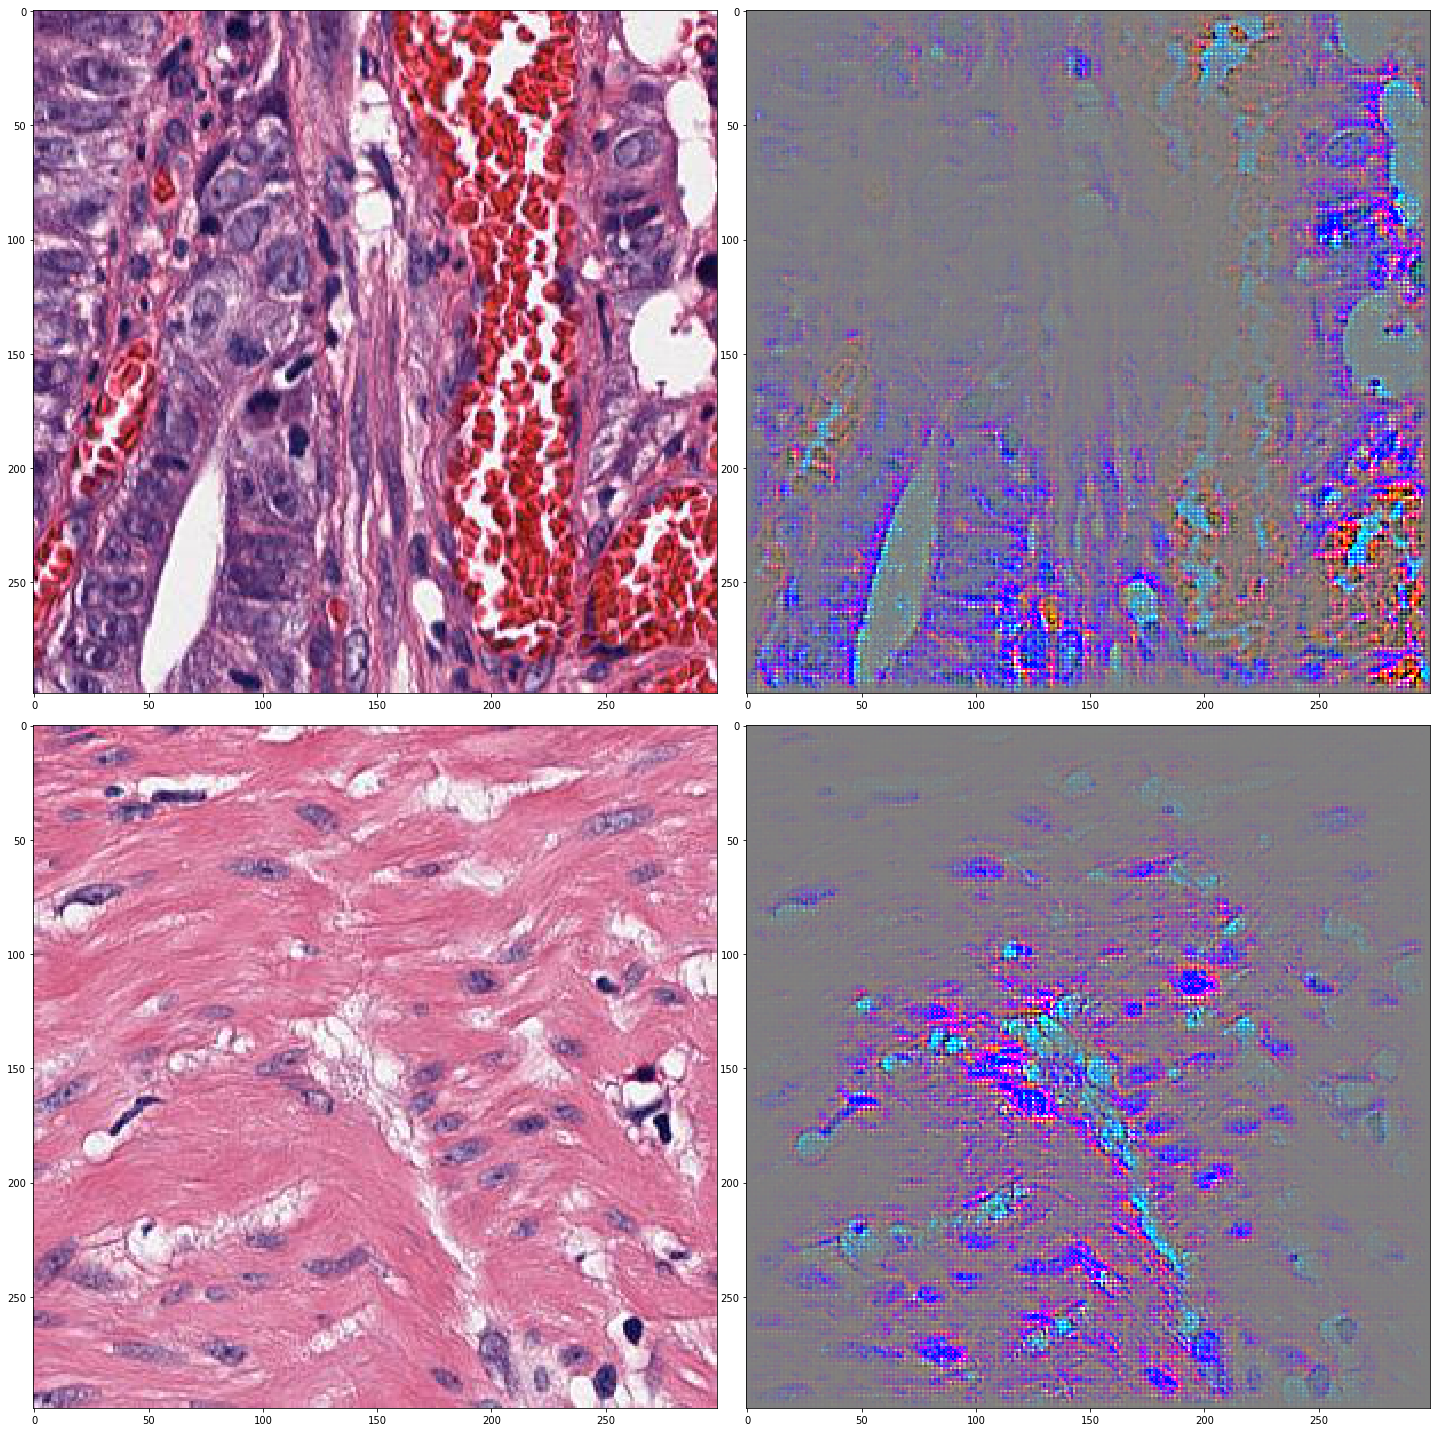

In [119]:
plot_cancer_normal(cancer_tile_o, guided_backprop_analysis_cancer, normal_tile_o, guided_backprop_analysis_normal)

## DeepTaylor

In [120]:
DeepTaylor_analyzer_cancer, DeepTaylor_analyzer_normal= generate_feature_heatmap(model_, 
                                                                                 "deep_taylor.bounded",
                                                                                 [cancer_tile, normal_tile],
                                                                                 heatmap,
                                                                                 {"low": 0, "high": 255})

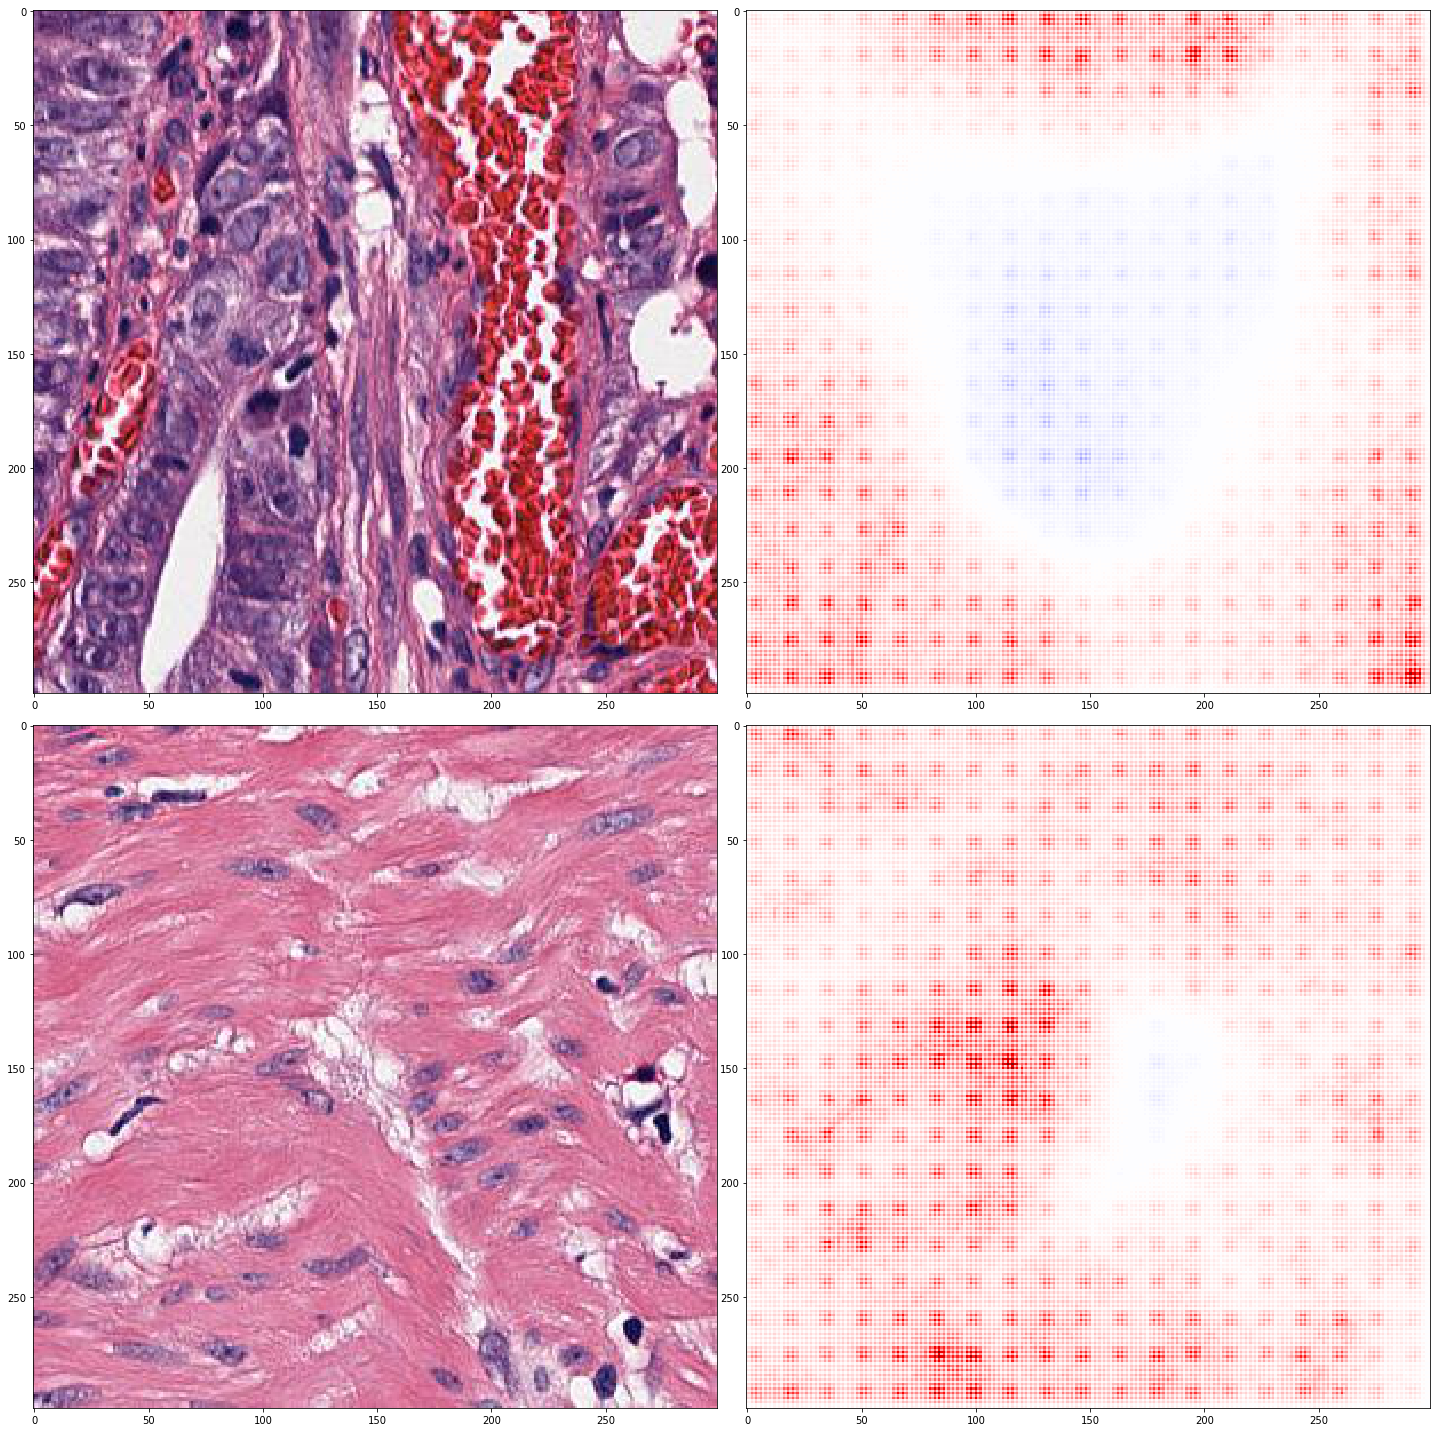

In [121]:
plot_cancer_normal(cancer_tile_o, DeepTaylor_analyzer_cancer, normal_tile_o, DeepTaylor_analyzer_normal)

## LRP-PresetAFlat

In [130]:
LRP_PresetAFlat_analyzer_cancer, LRP_PresetAFlat_analyzer_normal= generate_feature_heatmap(model_, 
                                                                                 "lrp.sequential_preset_a_flat",
                                                                                 [cancer_tile, normal_tile],
                                                                                 heatmap,
                                                                                 {"epsilon": 1})

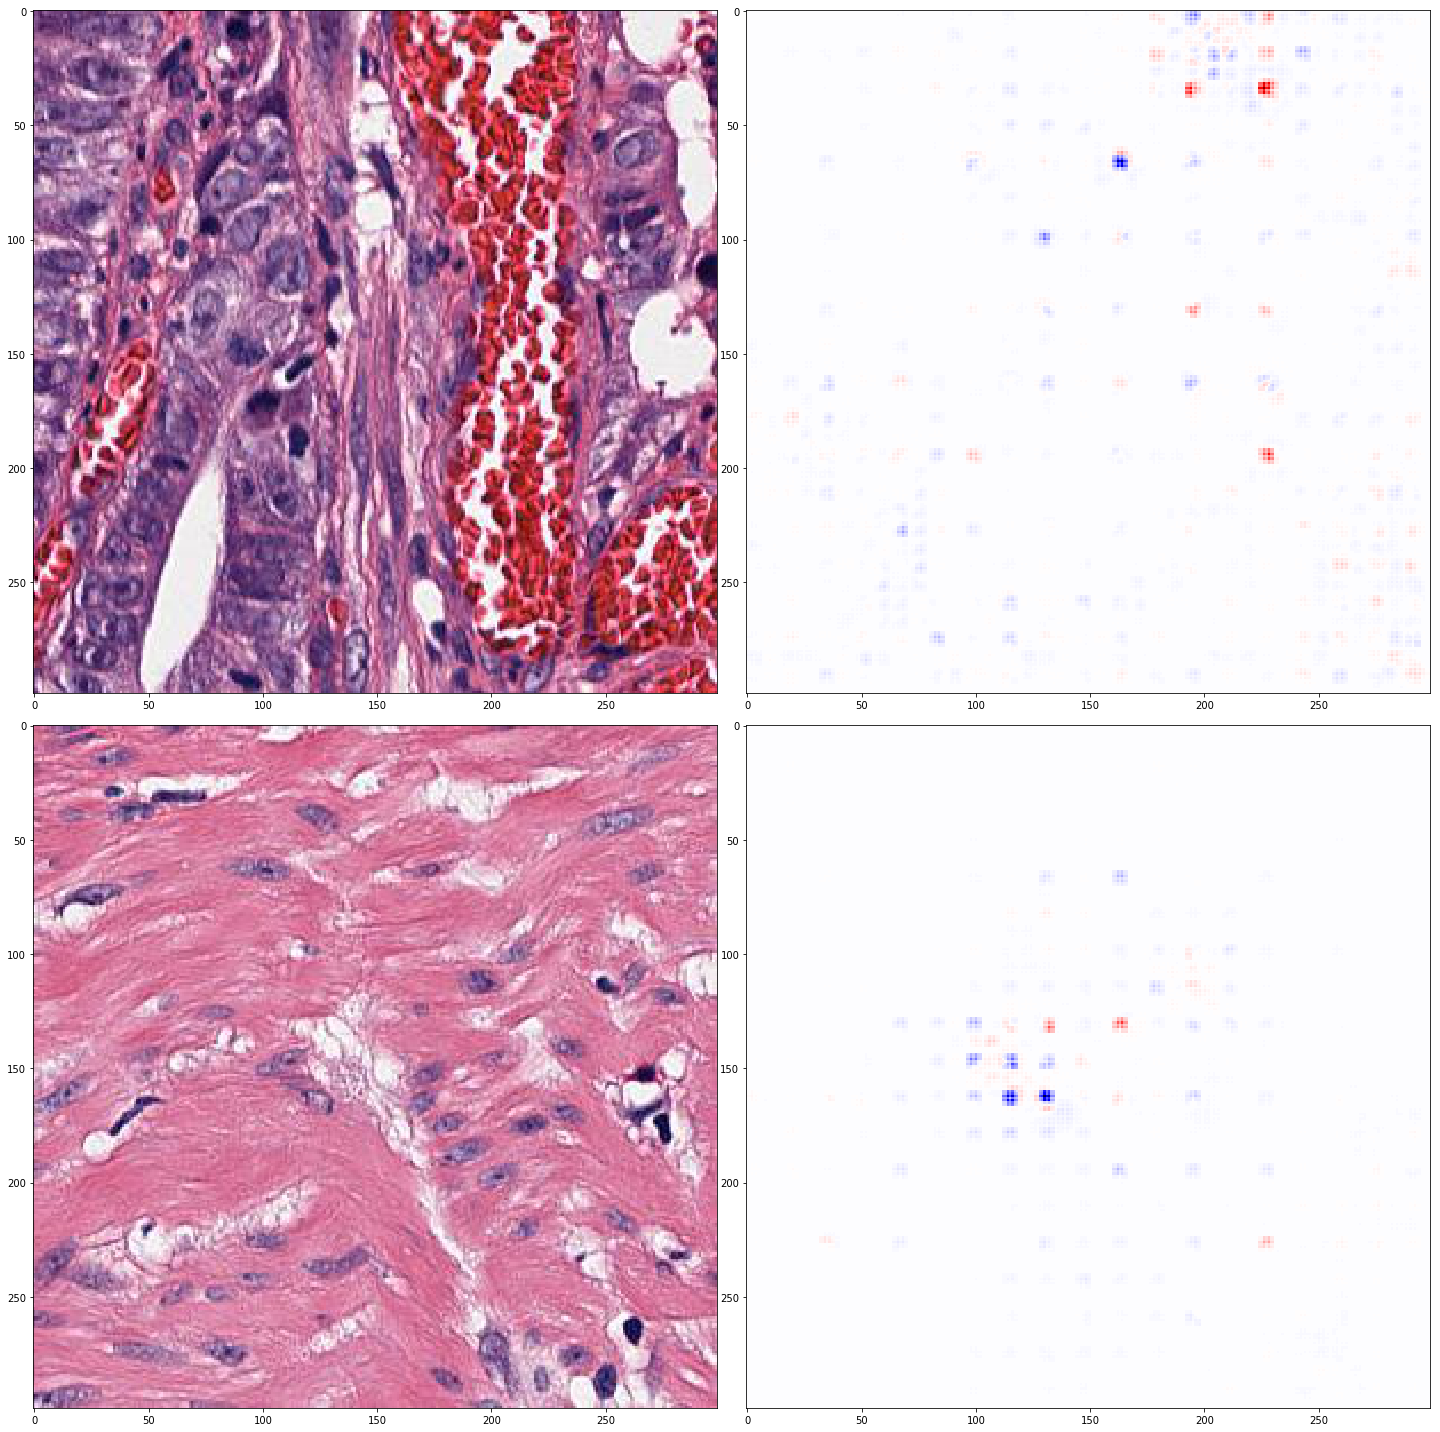

In [131]:
plot_cancer_normal(cancer_tile_o, LRP_PresetAFlat_analyzer_cancer, normal_tile_o, LRP_PresetAFlat_analyzer_normal)

## LRP-Epsilon

In [124]:
LRP_Epsilon_analyzer_cancer, LRP_Epsilon_analyzer_normal= generate_feature_heatmap(model_, 
                                                                                 "lrp.epsilon",
                                                                                 [cancer_tile, normal_tile],
                                                                                 heatmap,
                                                                                 {"epsilon": 1})

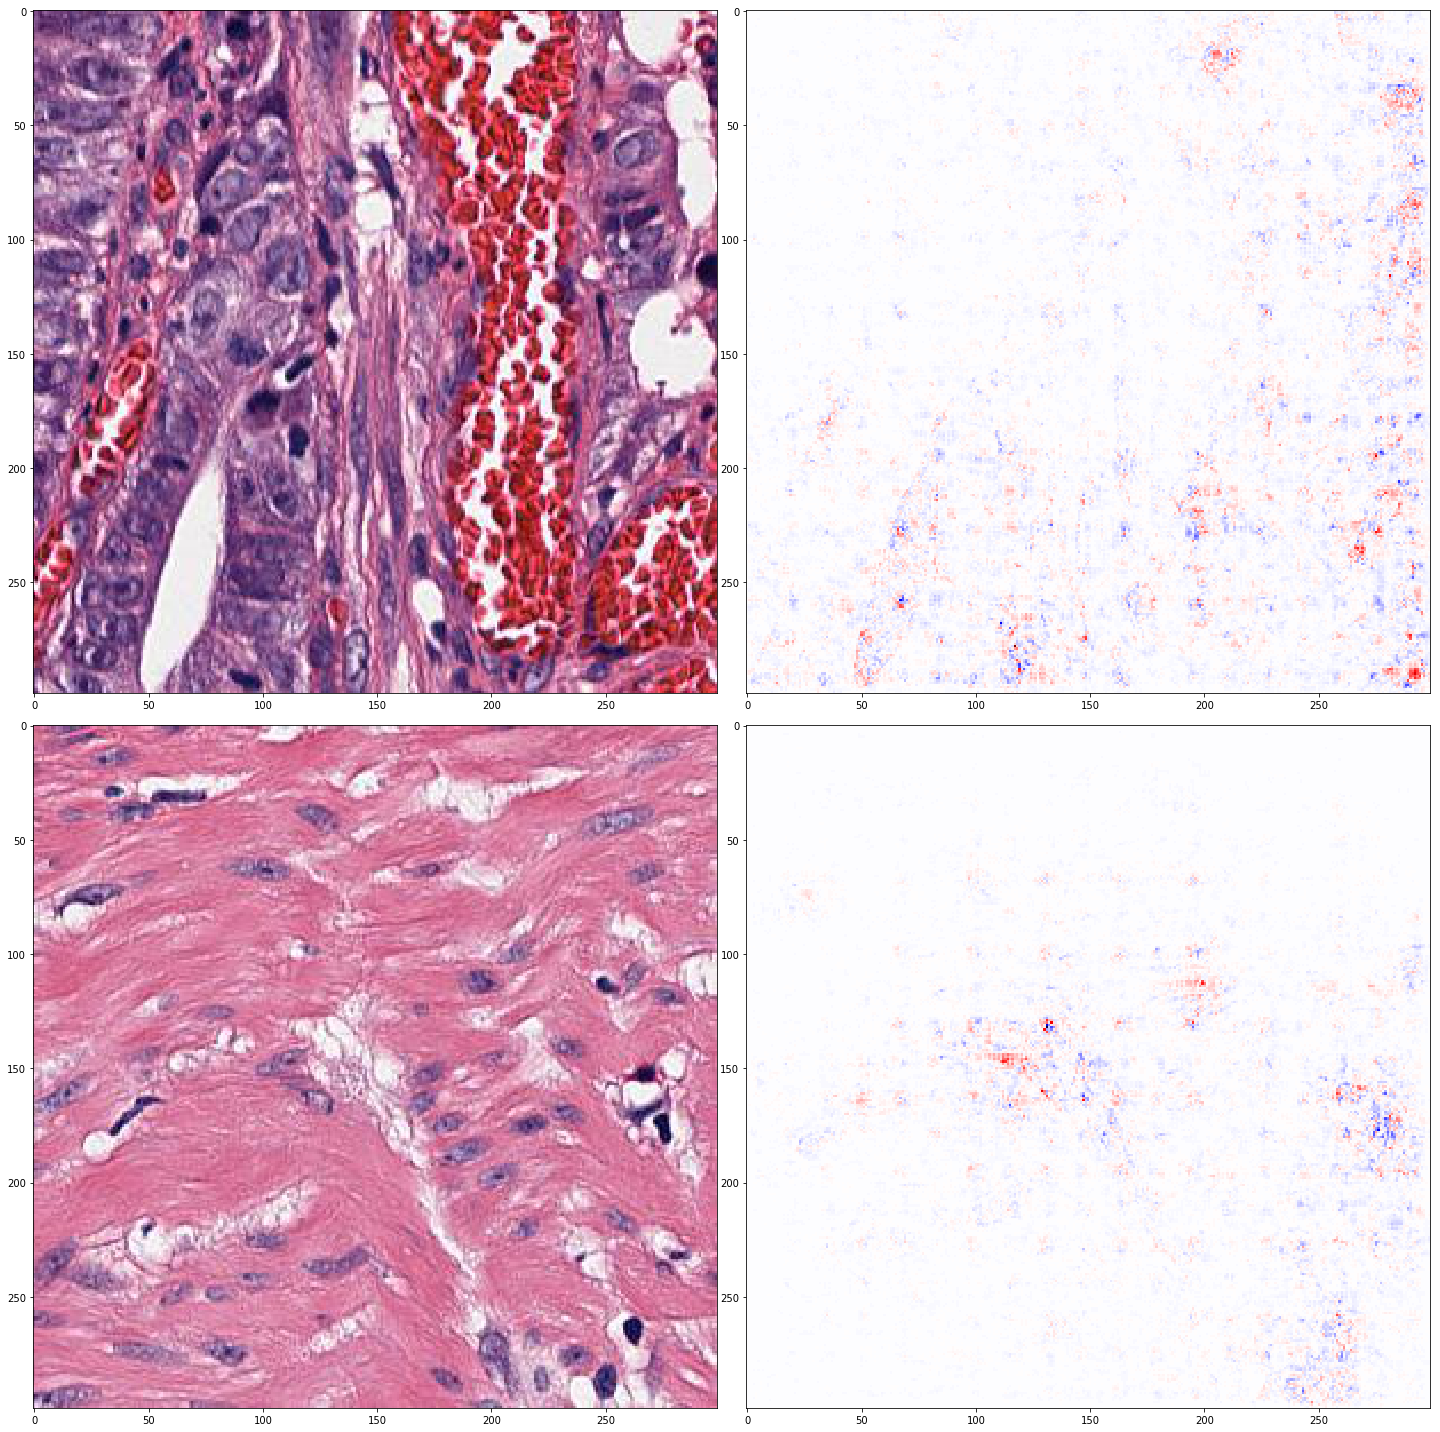

In [125]:
plot_cancer_normal(cancer_tile_o, LRP_Epsilon_analyzer_cancer, normal_tile_o, LRP_Epsilon_analyzer_normal)

In [139]:
noise_scale = 255 * 0.1
# Methods we use and some properties.
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN                TITLE
    # Show input.
    ("input",                 {},                       o_image,         "Input"),

    # Function
    ("gradient",              {"postprocess": "abs"},   graymap,       "Gradient"),

    # Signal
    ("deconvnet",             {},                       bk_proj,       "Deconvnet"),
    ("guided_backprop",       {},                       bk_proj,       "Guided Backprop",),
    

    # Interaction
    
    ("deep_taylor.bounded",   {"low": 0,
                               "high": 255},            heatmap,       "DeepTaylor"),
    ("input_t_gradient",      {},                       heatmap,       "Input * Gradient"),
    ("lrp.z",                 {},                       heatmap,       "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           heatmap,       "LRP-Epsilon"),
    ("lrp.sequential_preset_a_flat",{"epsilon": 1},     heatmap,       "LRP-PresetAFlat"),
    ("lrp.sequential_preset_b_flat",{"epsilon": 1},     heatmap,       "LRP-PresetBFlat"),
]

In [140]:
analyzers = []
for method in methods:
    try:
        analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                                model_wo_sm,      # model without softmax output
                                                **method[1])      # optional analysis parameters
    except innvestigate.NotAnalyzeableModelException:
        # Not all methods work with all models.
        analyzer = None
    analyzers.append(analyzer)

In [141]:
analysis = np.zeros([1, len(analyzers)]+[299,299]+[3])
text = []

In [142]:
x_batch = np.array([cancer_tile])

In [143]:
# Predict final activations, probabilites, and label.
presm = model_wo_sm.predict_on_batch(x_batch)[0]
prob = model_.predict_on_batch(x_batch)[0]
y_hat = prob.argmax()
label_to_class_name = ["Cancer", "Normal"]

In [144]:
# Save prediction info:
text.append(("%s" % label_to_class_name[0],    # ground truth label
             "%.2f" % presm.max(),             # pre-softmax logits
             "%.2f" % prob.max(),              # probabilistic softmax output  
             "%s" % label_to_class_name[y_hat] # predicted label
            ))

In [145]:
for aidx, analyzer in enumerate(analyzers):
    if methods[aidx][0] == "input":
        # Do not analyze, but keep not preprocessed input.
        a = np.array([cancer_tile]).astype(np.float32)
    elif analyzer:
        # Analyze.
        a = analyzer.analyze(x_batch)

        # Apply analysis postprocessing, e.g., creating a heatmap.
        a = methods[aidx][2](a)
    else:
        a = np.zeros_like(image)
    # Store the analysis.
    analysis[0, aidx] = a[0]

W1107 16:23:48.714428 140627564644160 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

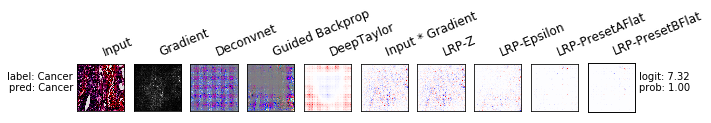

In [146]:
# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]  
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]),'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]),'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

# Plot the analysis.
eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                       file_name=os.environ.get("plot_file_name", None))